### Optimal Transport

#### Embeddings

In [ ]:
from Process_Data.Datasets.KaldiDataset import ScriptTrainDataset
from Light.dataset import Sampler_Loaders, SubScriptDatasets

import os
from hyperpyyaml import load_hyperpyyaml
from Light.model import SpeakerLoss
from geomloss import SamplesLoss

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from tqdm import tqdm
import pandas as pd
import numpy as np

In [ ]:
torch.cuda.set_device(1)
device = 'cuda:1'

In [3]:
data_root = '/home/yangwenhao/project/SpeakerVerification-pytorch'

In [4]:
# train_config = 'data/vox2/model.2024.01.29.yaml'
train_config = 'data/vox1/model.2024.03.15.yaml'

In [5]:
with open(train_config, 'r') as f:
    config_args = load_hyperpyyaml(f)

In [6]:
if 'embedding_model' in config_args:
    model = config_args['embedding_model']

if 'classifier' in config_args:
    model.classifier = config_args['classifier']
# else:
#     if not isinstance(model.classifier, Classifier):
#         create_classifier(model, **config_args)

In [7]:
model.loss = SpeakerLoss(config_args)
model = model.cuda()

In [8]:
# resume = 'Data/checkpoint/ECAPA_brain/Mean_batch96_SASP2_em192_official_2s/arcsoft_adam_cyclic/vox2/wave_fb80_dist_aug53/1234/checkpoint_3.pth'
epoch = 'avg3' #'3'
resume = 'Data/checkpoint/ECAPA_brain/Mean_batch96_SASP2_em192_official_2s/arcsoft_adam_cyclic/vox1/wave_fb80_inst_aug53/1234/checkpoint_{}.pth'.format(epoch)
checkpoint = torch.load(os.path.join(data_root, resume), map_location='cpu') #, map_location='cuda:1')

start_epoch = checkpoint['epoch']
checkpoint_state_dict = checkpoint['state_dict']
if isinstance(checkpoint_state_dict, tuple):
    checkpoint_state_dict = checkpoint_state_dict[0]

filtered = {k: v for k, v in checkpoint_state_dict.items(
) if 'num_batches_tracked' not in k}

# filtered = {k: v for k, v in checkpoint['state_dict'].items() if 'num_batches_tracked' not in k}
if list(filtered.keys())[0].startswith('module'):
    new_state_dict = OrderedDict()
    for k, v in filtered.items():
        # remove `module.`，表面从第7个key值字符取到最后一个字符，去掉module.
        new_state_dict[k[7:]] = v  # 新字典的key值对应的value为一一对应的值。

    model.load_state_dict(new_state_dict)
else:
    model_dict = model.state_dict()
    model_dict.update(filtered)
    model.load_state_dict(model_dict)

In [9]:
config_args['verbose'] = 1
config_args['save_data_dir'] = data_root + '/' + config_args['save_data_dir']

In [10]:
train_dir, valid_dir, train_extract_dir = SubScriptDatasets(config_args)

==> There are 1211 speakers in Dataset.
    There are 148642 utterances in Trainset, where 0 utterances are removed.
    Spliting 2422 utterances for Validation.
    Loading training samples from:
	 /home/yangwenhao/project/SpeakerVerification-pytorch/Data/checkpoint/ECAPA_brain/Mean_batch96_SASP2_em192_official_2s/arcsoft_adam_cyclic/vox1/wave_fb80_inst/train.csv 
    Sample 386317 segments for speakers.
Examples uids:  ['id10001-J9lHsKG98U8-00015', 'id10001-J9lHsKG98U8-00024', 'id10002-RLKKsYiCMvc-00006', 'id10002-eNc4LrrvV80-00013']


In [18]:
labels = [u for u,s,e in train_dir.base_utts]
labels = [u.split('-')[0] for u in labels]
labels = np.array([train_dir.spk_to_idx[l] for l in labels])

In [11]:
batch_size = config_args['batch_size'] // 2
num_classes = config_args['num_classes']

batch_loader = torch.utils.data.DataLoader(
    train_dir, batch_size=batch_size, num_workers=config_args['nj'])
sample_num = len(train_dir)

In [12]:
config_args['num_classes']

1211

In [13]:
embedding_dim = config_args['embedding_size']
embeddings = torch.zeros([len(train_dir), embedding_dim], requires_grad=False)
grads = torch.zeros([len(train_dir), embedding_dim], requires_grad=False)

logits = torch.zeros([len(train_dir), config_args['num_classes']], requires_grad=False)

In [20]:
pbar = tqdm(enumerate(batch_loader), ncols=50, total=len(batch_loader))
model.eval()

with torch.no_grad():
    for i, (data, label) in pbar:

        logit, embedding = model(data.to(device))
        loss, _ = model.loss(logit, label.to(device), batch_weight=None, other=True)

        embedding = embedding.detach().cpu()
        logit = logit.detach().cpu()

        embeddings[i * batch_size:min((i+1) * batch_size, sample_num)] += embedding
        logits[i * batch_size:min((i+1) * batch_size, sample_num)] += logit

        # break

  0%|                    | 0/8049 [00:00<?, ?it/s]


In [29]:
# torch.save({'embeddings': embeddings}, 'data/vox2/embeddings.pth')
torch.save({'embeddings': embeddings}, 'data/vox1_inst/embeddings.pth')
torch.save({'logits': logits}, 'data/vox1_inst/logits.pth')

In [26]:
# embeddings = torch.load('data/vox2/embeddings.pth')['embeddings']
# grads = torch.load('data/vox1_inst/grads.pth')['grads']
embeddings = torch.load('data/vox1_inst/embeddings.pth')['embeddings']

In [33]:
from Process_Data.Datasets.SelectDataset import Dist_loss

import numpy as np

In [20]:
batch_size = 96

In [21]:
device = torch.device('cuda:1')

### Optimal Tranport and Multi-scale distance

In [14]:
from Process_Data.Datasets.SelectDataset import cost_func

class Dist_loss(nn.Module):
    def __init__(self, w, metric='cosine'):
        super(Dist_loss, self).__init__()
        w = w/w.mean()
        self.w = nn.Parameter(w)
        self.loss = SamplesLoss("sinkhorn", p=2, blur=0.05,
                                cost=lambda a, b: cost_func(a, b, p=2, metric=metric))
                                # SamplesLoss("sinkhorn", p=2, blur=0.1)
    def forward(self, x1, x2):
        w = torch.nn.functional.softmax(self.w, dim=0)
        # w =  torch.clamp(self.w, min=0, max=2, out=None)
        w = w / w.mean()
        
        return self.loss(w*x1, x2)
    
from Define_Model.ParallelBlocks import gumbel_softmax_sample

def gumbel_softmax(logits, num=1, temperature = 5):
    """
    input: [*, n_class]
    return: [*, n_class] an one-hot vector
    """
    y = gumbel_softmax_sample(logits, temperature)
    shape = y.size()
    y_sort_idx = torch.argsort(y, dim=1)
    # _, ind = y.max(dim=-1)
    ind = y_sort_idx[:, -num:]
    # print(y_sort_idx.shape, ind)
    y_hard = torch.zeros_like(y).view(-1, shape[-1])
    # y_hard.scatter_(1, ind.view(-1, 1), 1)
    y_hard.scatter_(1, ind, 1)
    y_hard = y_hard.view(*shape)
    return (y_hard - y).detach() + y

class MultiRatioDist_loss(nn.Module):
    def __init__(self, w, metric='cosine',
                ratios=[0.1, 0.25, 0.5, 0.75, 0.9],
                sample_ratio=3):
        super(MultiRatioDist_loss, self).__init__()

        self.w = nn.Parameter(w)
        self.loss = SamplesLoss("sinkhorn", p=2, blur=0.05,
                                cost=lambda a, b: cost_func(a, b, p=2, metric=metric))
                                # SamplesLoss("sinkhorn", p=2, blur=0.1)
        self.ratios = ratios
        self.sample_ratio = sample_ratio
        
    def forward(self, x1, x2):

        loss = 0
        if self.sample_ratio < len(self.ratios):
            ratios = np.random.choice(self.ratios, self.sample_ratio, replace=False)
        else:
            ratios = self.ratios
            
        for r in ratios:
            idx = gumbel_softmax(self.w.reshape(1, -1), num=int(len(self.w)*r)).squeeze().reshape(-1,1)
            x11 = x1*idx
            loss = loss + self.loss(x11, x2)
                
        return loss / len(ratios)


class MultiRatioDiscrepencyDist_loss(nn.Module):
    def __init__(self, w, metric='cosine',
                ratios=[0.1, 0.25, 0.5, 0.75, 0.9],
                sample_ratio=3):
        super(MultiRatioDiscrepencyDist_loss, self).__init__()

        self.w = nn.Parameter(w)
        self.loss = SamplesLoss("sinkhorn", p=2, blur=0.05,
                                cost=lambda a, b: cost_func(a, b, p=2, metric=metric))
                                # SamplesLoss("sinkhorn", p=2, blur=0.1)
        self.ratios = ratios
        self.sample_ratio = sample_ratio
        
    def forward(self, x1, x2):

        loss = 0
        if self.sample_ratio < len(self.ratios):
            ratios = np.random.choice(self.ratios, self.sample_ratio, replace=False)
        else:
            ratios = self.ratios
        
        standard_loss = self.loss(x1, x2)
        
        for r in ratios:
            idx = gumbel_softmax(self.w.reshape(1, -1), num=int(len(self.w)*r)).squeeze().reshape(-1,1)
            x11 = x1*idx
            loss = loss + (self.loss(x11, x2) - standard_loss).abs()
                
        return loss / len(ratios)

In [53]:
np.random.choice([1,2,3,4,5,6], 4, replace=False)

array([1, 3, 6, 5])

In [ ]:
gumbel_softmax

In [144]:
samples = np.arange(sample_num)
batch_samples = []
for i in range(optimizer_time):
    np.random.shuffle(samples)
    batch_samples.append(samples[:int(sample_num / batch_size) * batch_size].reshape(-1, batch_size))

batch_samples = np.concatenate(batch_samples, axis=0)

In [146]:
bigger_samples = np.arange(sample_num)
bigger_batch_samples = []
bigger_batch_size = int(batch_size*4)

for i in range(optimizer_time*2):
    np.random.shuffle(bigger_samples)
    
    bigger_batch_samples.append(bigger_samples[:int(sample_num / bigger_batch_size) * bigger_batch_size].reshape(-1, bigger_batch_size))
    
bigger_batch_samples = np.concatenate(bigger_batch_samples, axis=0)

In [147]:
print(bigger_batch_samples.shape, batch_samples.shape)

(752, 2048) (1508, 512)


In [162]:
repeat = 1
optimizer_time = 4
metric = 'euclidean'
batch_size = 1024
optimize_vector = 'embeddings'
wss = []
random_seed = 1234
sample_ratio = 5
steps = 20
lr = 0.1

for cur_repeat in range(repeat):
    np.random.seed(random_seed)
    random_seed = random_seed - 5

    ws =  torch.ones(sample_num, 1)
    total_set = set(np.arange(sample_num))
    
    bigger_samples = np.arange(sample_num)
    bigger_batch_samples = []
    bigger_batch_size = int(batch_size*4)

    for i in range(optimizer_time*4):
        np.random.shuffle(bigger_samples)
        bigger_batch_samples.append(bigger_samples[:int(sample_num / bigger_batch_size) * bigger_batch_size].reshape(-1, bigger_batch_size))

    bigger_batch_samples = np.concatenate(bigger_batch_samples, axis=0)
    
    samples = np.arange(sample_num)
    batch_samples = []
    for i in range(optimizer_time):
        np.random.shuffle(samples)
        batch_samples.append(samples[:int(sample_num / batch_size) * batch_size].reshape(-1, batch_size))

    batch_samples = np.concatenate(batch_samples, axis=0)

    # pbar = tqdm(range(int(sample_num/batch_size*optimizer_time)), ncols=50)
    pbar = tqdm(range(len(batch_samples)), ncols=50)

    for i in pbar:
        
        select_ids = batch_samples[i]
        other_set = bigger_batch_samples[i%(bigger_batch_samples.shape[0])]
        
        if optimize_vector == 'embeddings':
            s_xvectors = embeddings[select_ids]
        elif optimize_vector == 'logits':
            s_xvectors = logits[select_ids]
        elif optimize_vector == 'grads':
            s_xvectors = grads[select_ids]
            
        x1 = s_xvectors.clone().cuda() #.to(device)
        
        # dloss = Dist_loss(ws[select_ids]).to(x1.device)
        dloss = MultiRatioDist_loss(ws[select_ids], metric='euclidean', sample_ratio=sample_ratio).to(x1.device)

        opt = torch.optim.Adam(dloss.parameters(), lr=lr, weight_decay=0)

        for j in range(steps):
            other_set = bigger_batch_samples[(i+j)%(bigger_batch_samples.shape[0])]
        
            if optimize_vector == 'embeddings':
                x2 = embeddings[other_set].clone().to(device)
            elif optimize_vector == 'logits':
                x2 = logits[other_set].clone().to(device)
            elif optimize_vector == 'grads':
                x2 = grads[other_set].clone().to(device)
                
            L_αβ = dloss(x1, x2)
            L_αβ.backward()
            opt.step()
            # print(dloss.w.data.squeeze()[:10])
            opt.zero_grad()
        
        w = dloss.w.data.cpu()
        ws[select_ids] = w #dloss.w.data.abs().cpu()
        # break
    
    wss.append(ws)

ws = torch.stack(wss, dim=0)
if ws.shape[0] > 1:
    ws = ws.mean(dim=0)
else:
    ws = ws.squeeze()

100%|███████| 1508/1508 [1:11:32<00:00,  2.85s/it]


In [163]:
print(ws.squeeze().min(), ws.squeeze().max())

tensor(-2.4893) tensor(9.0417)


In [164]:
ws.squeeze().shape, sample_num

(torch.Size([386317]), 386317)

In [165]:
torch.save({'scores': ws.squeeze()}, 'data/vox1_inst/scores.mulscale.v1.lr0.1.steps20.time4.batch1024.x2s.pth')

In [15]:
# scores = torch.load('data/vox1_inst/scores.mulscale.v1.lr0.1.steps20.time4.logits.pth')['scores']
scores = torch.load('data/vox1_inst/scores.mulscale.v1.lr0.1.steps20.time4.batch1024.x2s.pth')['scores']

In [161]:
train_utts = pd.DataFrame(train_dir.base_utts, columns=['uid', 'start', 'end'])
train_utts['scores'] = scores #ws.squeeze().numpy()

save_dir = '/home/yangwenhao/project/SpeakerVerification-pytorch/Data/checkpoint/ECAPA_brain/Mean_batch96_SASP2_em192_official_2s/arcsoft_adam_cyclic/vox1/wave_fb80_inst_aug53_oneshot_lr_muloptimal_logits'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
train_utts.to_csv(os.path.join(save_dir, 'subtrain.{}.scores.csv'.format(0)),
                  index=None)

### batch size should be related to the ratio of subset

In [199]:
from Define_Model.ParallelBlocks import gumbel_softmax_sample

def gumbel_softmax(logits, num=1, temperature = 5):
    """
    input: [*, n_class]
    return: [*, n_class] an one-hot vector
    """
    y = gumbel_softmax_sample(logits, temperature)
    shape = y.size()
    y_sort_idx = torch.argsort(y, dim=1)
    # _, ind = y.max(dim=-1)
    ind = y_sort_idx[:, -num:]
    # print(y_sort_idx.shape, ind)
    y_hard = torch.zeros_like(y).view(-1, shape[-1])
    # y_hard.scatter_(1, ind.view(-1, 1), 1)
    y_hard.scatter_(1, ind, 1)
    y_hard = y_hard.view(*shape)
    return (y_hard - y).detach() + y

In [220]:
w.squeeze()[gumbel_softmax(w.cuda().reshape(1, -1), num=10).squeeze().bool()]

torch.Size([1, 512]) tensor([[402,  97, 107, 234, 347,  87, 222, 180, 114, 322]], device='cuda:1')


tensor([1.2529, 0.7807, 1.0882, 1.1323, 0.6588, 1.1155, 1.0709, 1.1681, 0.9610,
        1.2499])

In [227]:
def gumbel_softmax(logits, num=1, temperature = 5):
    """
    input: [*, n_class]
    return: [*, n_class] an one-hot vector
    """
    y = gumbel_softmax_sample(logits, temperature)
    shape = y.size()
    y_sort_idx = torch.argsort(y, dim=1)
    # _, ind = y.max(dim=-1)
    ind = y_sort_idx[:, -num:]
    # print(y_sort_idx.shape, ind)
    y_hard = torch.zeros_like(y).view(-1, shape[-1])
    # y_hard.scatter_(1, ind.view(-1, 1), 1)
    y_hard.scatter_(1, ind, 1)
    y_hard = y_hard.view(*shape)
    return (y_hard - y).detach() + y

In [187]:
dloss.w.shape,x1.shape

(torch.Size([512, 1]), torch.Size([512, 192]))

  20    14  442.0161  441.9662


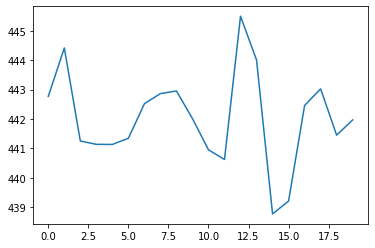

In [153]:
x1 = s_xvectors.clone().cuda() #.to(device)
steps = 20
sample_ratio = 5
lr = .1
ratios=[0.1, 0.25, 0.5, 0.75, 0.9]

# for steps in [20]:
# for lr in [4, 2, 1, 0.1, 0.01]:
for steps in [20]:
    for sample_ratio in [5]:

        losses = []
        dloss = MultiRatioDist_loss(ws[select_ids], metric='euclidean', sample_ratio=sample_ratio).to(x1.device)
        # dloss = MultiRatioDiscrepencyDist_loss(ws[select_ids], metric='euclidean', 
        #                                        ratios=ratios,
        #                                        sample_ratio=sample_ratio).to(x1.device)

        opt = torch.optim.Adam(dloss.parameters(), lr=lr, weight_decay=0)
        np.random.seed(1234)
        for i in range(steps):
            other_set = bigger_batch_samples[i//2]
            x2 = embeddings[other_set].clone().to(device)
            L_αβ = dloss(x1, x2)
            # L_αβ = dloss(x1, x1)
            
            losses.append(float(L_αβ.item()))
            L_αβ.backward()
            opt.step()
            opt.zero_grad()
                # w = torch.clamp(dloss.w.data.cpu(), min=0, max=2, out=None) #dloss.w.data.squeeze().abs()

        plt.plot(losses)
        print('{: >4}  {: >4}  {:.4f}  {:.4f}'.format(steps, np.argmin(losses), np.mean(losses), losses[-1]))
    
# 0.1
# 20 503.4534 19 
# 30 503.4202 20 
# 40 503.2956 39 
# 60 503.2195 48 

# 0.2
# 20 504.0794 19 
# 30 503.4644 28 
# 40 503.2004 36 
# 60 503.0920 47

# 0.3
# 20 504.4903 18 
# 30 503.6195 29 
# 40 503.3297 39 
# 60 503.1680 56 

# 0.1
# 20 449.2462 17 
# 30 449.2888 20 
# 40 448.8777 15 
# 60 450.0882 18

# sample_ratio = 5 lr=1,
# 20 23.1627 13 
# 40 21.6203 12 
# 80 19.1648 43 
# 200 21.1245 62

In [ ]:
w[torch.argsort(w)]

503.200439453125


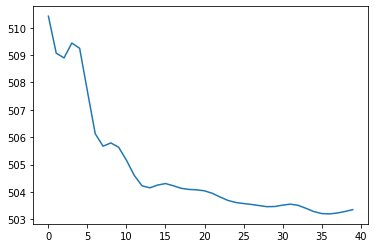

In [124]:
plt.plot(losses)
print(np.min(losses))

In [50]:
w = torch.nn.functional.softmax(dloss.w.data.cpu().squeeze(), dim=0)
# w =  torch.clamp(self.w, min=0, max=2, out=None)
w = w / w.mean()

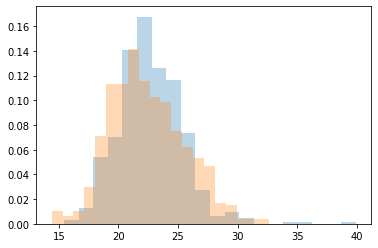

In [77]:
_ = plt.hist(x1.norm(dim=1).cpu(), bins=20, alpha=0.3, density=True)
_ = plt.hist(x1.norm(dim=1).cpu()*w, bins=20, alpha=0.3, density=True)

In [154]:
w = torch.nn.functional.softmax(dloss.w.data.cpu().squeeze(), dim=0)
# w = torch.clamp(self.w, min=0, max=2, out=None)
w = w / w.mean()

y     = x1.norm(dim=1).cpu()
idx   = torch.sort(y).indices
idx_w = torch.sort(w).indices

In [155]:
print(w.min(), w.max())

tensor(0.0431) tensor(17.7399)


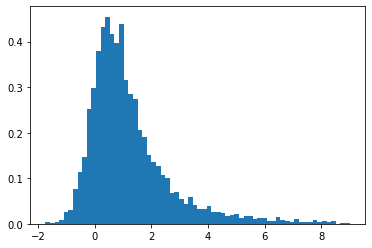

In [17]:
# _ = plt.hist(w, bins='auto', density=True)
_ = plt.hist(scores.squeeze().numpy()[:5120], bins='auto', density=True)

In [ ]:
w[idx_w]

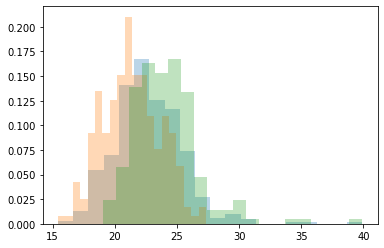

In [89]:
_ = plt.hist(y, bins=20, alpha=0.3, density=True)
_ = plt.hist(y[idx_w[-200:]], bins=20, alpha=0.3, density=True)
_ = plt.hist(y[idx_w[:200]], bins=20, alpha=0.3, density=True)


In [34]:
from geomloss import SamplesLoss

In [35]:
loss_func = SamplesLoss("sinkhorn", p=2, blur=0.05, cost=lambda a, b: cost_func(a, b, p=2, metric='euclidean'))

In [91]:
op_1 = loss_func(x1[idx_w[-200:]], x2)
op_2 = loss_func(x1[idx_w[:200]], x2)
print(op_1.float(), op_2)

tensor(513.7578, device='cuda:1') tensor(627.0327, device='cuda:1')


In [157]:
print("   #Samples   |  max_opx2  |  min_opx2 |  max_opx1  |  min_opx1 |   x1_x2   |  x2_x2  |   random1 |  random2  |")
np.random.seed(1234)
for r in [0.1, 0.25, 0.5, 0.75, 0.9, 0.95]:
    
    ops= []
    for x2_idx in range(10):
        other_set = bigger_batch_samples[x2_idx*4]
        x2 = embeddings[other_set].clone().to(device) 
        
        num = int(r*len(idx_w))
        op_1 = loss_func(x1[idx_w[-num:]], x2)
        op_2 = loss_func(x1[idx_w[:num]], x2)
        op_11 = loss_func(x1[idx_w[-num:]], x1)
        op_22 = loss_func(x1[idx_w[:num]], x1)
        op_3 = loss_func(x1, x2)
        op_4 = loss_func(x2, x2)
        # print(op_1.float(), op_2)
        
        ops.append([float(op_1), float(op_2),float(op_11), float(op_22), float(op_3), float(op_4)])
        
    ops = np.mean(ops, axis=0)

    loss_rand1 = []
    for i in range(10):
        x1_samples = np.arange(len(x1))
        np.random.shuffle(x1_samples)
        rand_idx = torch.LongTensor(x1_samples[-num:]).to(device)
        loss_rand1.append(loss_func(x1[rand_idx], x1).cpu().float())
    
    loss_rand2 = []
    for i in range(10):
        x1_samples = np.arange(len(x1))
        np.random.shuffle(x1_samples)
        rand_idx = torch.LongTensor(x1_samples[-num:]).to(device)
        loss_rand2.append(loss_func(x1[rand_idx], x2).cpu().float())

    print(" {: >5d} ({:4>.2f}) |   {:.3f}  |  {:.3f}  |   {:>7.3f}  |  {:>7.3f}  |  {:.3f}  |  {:.3f}  |  {:>7.3f}  |  {:>7.3f}  |".format(num, r, ops[0],ops[1],ops[2],ops[3],ops[4],
                                                                                                 ops[5], np.mean(loss_rand1), np.mean(loss_rand2)))
    
   # #Samples   |    max_op  |  min_op   |   x1_x2   |  x2_x2  |   random  |
   #    51      |   591.282  |  755.204  |  503.421  |  0.000  |  654.000  |
   #   128      |   534.334  |  661.014  |  503.421  |  0.000  |  590.209  |
   #   256      |   503.825  |  594.438  |  503.421  |  0.000  |  547.005  |
   #   384      |   496.292  |  547.888  |  503.421  |  0.000  |  520.241  |
   #   460      |   498.988  |  522.620  |  503.421  |  0.000  |  509.579  |

   #Samples   |  max_opx2  |  min_opx2 |  max_opx1  |  min_opx1 |   x1_x2   |  x2_x2  |   random1 |  random2  |
   102 (0.10) |   549.193  |  711.371  |   504.763  |  621.699  |  465.170  |  0.000  |  534.275  |  608.008  |
   256 (0.25) |   497.873  |  616.473  |   392.503  |  439.980  |  465.170  |  0.000  |  401.117  |  550.554  |
   512 (0.50) |   472.373  |  543.353  |   257.431  |  249.740  |  465.170  |  0.000  |  247.563  |  504.910  |
   768 (0.75) |   462.458  |  500.732  |   134.045  |  111.193  |  465.170  |  0.000  |  116.329  |  482.236  |
   921 (0.90) |   461.854  |  479.991  |    56.562  |   41.437  |  465.170  |  0.000  |   46.454  |  471.102  |
   972 (0.95) |   462.731  |  472.757  |    29.583  |   19.926  |  465.170  |  0.000  |   23.067  |  467.936  |


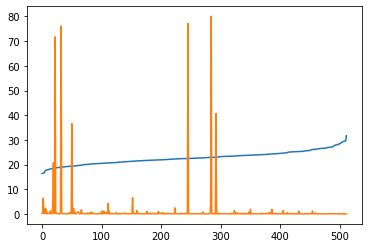

In [263]:
plt.plot(y[idx])
plt.plot(w[idx])
# plt.plot((y*w)[idx])

In [ ]:
x1.norm(dim=1).cpu()*w

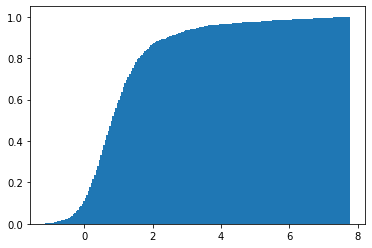

In [272]:
_ = plt.hist(ws.squeeze()[:2000], bins=200, cumulative=True, density=True)
# plt.xscale('log')

In [ ]:
# dloss.w.grad
# ws[:100]
idx = torch.sort(ws.squeeze()).indices
ws[idx[-100:]]

In [116]:
idx.shape

torch.Size([386301, 1])

In [550]:
torch.save({'weights': ws}, 'data/vox2/weight.adam.512.pth')

In [286]:
import pandas as pd

In [287]:
train_utts = pd.DataFrame(train_dir.base_utts, columns=['uid', 'start', 'end'])
train_utts['scores'] = ws.squeeze().numpy()

train_utts.to_csv(os.path.join('data/vox2', 'subtrain.{}.scores.csv'.format(0)),
                  index=None)

In [293]:
scores_utts = pd.read_csv(os.path.join('data/vox2', 'subtrain.{}.scores.csv'.format(0))).to_numpy()

In [295]:
scores_utts[:, -1].astype(np.float32)

array([1.0109581 , 1.0425051 , 0.9720516 , ..., 0.98818487, 1.007649  ,
       1.0005752 ], dtype=float32)

In [299]:
isinstance(scores_utts, np.ndarray)

True

In [298]:
type(np.array([0]))

numpy.ndarray

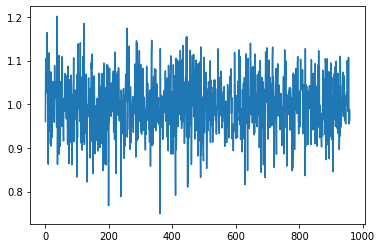

In [551]:
plt.plot(ws[:192*5])

In [276]:
 torch.clamp(dloss.w, min=0, max=None, out=None).squeeze()

tensor([1.0847, 0.7928, 0.9437, 0.9226, 1.0970, 0.9642, 0.8300, 0.7533, 1.0684,
        0.9703, 1.2075, 0.8556, 0.9872, 1.0142, 0.8874, 0.9423, 1.0489, 0.8062,
        0.9436, 0.9211, 0.7868, 0.8112, 1.0417, 0.9621, 1.1970, 0.6961, 0.7554,
        0.8663, 1.1496, 0.8346, 0.9528, 1.0622, 1.2156, 0.9771, 1.1184, 0.8449,
        1.0420, 1.2011, 1.0929, 0.9940, 0.9283, 1.2092, 0.9854, 0.9348, 1.0021,
        0.8265, 1.0707, 1.1061, 1.1406, 1.1476, 1.1865, 0.9351, 0.9794, 1.1467,
        0.9899, 1.0639, 0.8515, 0.9758, 0.8566, 0.9828, 0.9257, 0.9806, 1.1537,
        0.9151, 1.0171, 1.0892, 1.1026, 0.7150, 1.0516, 1.0144, 1.2819, 1.0385,
        1.1359, 1.0043, 0.9578, 0.9713, 1.2582, 1.0290, 0.9604, 1.1242, 0.9068,
        0.8332, 0.9394, 0.9187, 1.1651, 0.6764, 0.7592, 1.2796, 0.9830, 1.0989,
        0.8486, 0.9984, 0.8949, 0.9937, 1.0046, 1.1887, 0.9522, 1.0982, 0.7692,
        0.9274, 0.9178, 0.9645, 1.0143, 1.0372, 1.1319, 0.9459, 1.2759, 1.0260,
        0.9607, 1.1045, 1.0587, 1.0580, 

In [507]:
# from Process_Data.Datasets.SelectDataset import cost_func

# class Dist_loss(nn.Module):
#     def __init__(self, w, metric='cosine'):
#         super(Dist_loss, self).__init__()
#         w = w/w.mean()
#         self.w = nn.Parameter(w)
#         self.loss = SamplesLoss("sinkhorn", p=2, blur=0.05,
#                                 cost=lambda a, b: cost_func(a, b, p=2, metric=metric))
#                                 # SamplesLoss("sinkhorn", p=2, blur=0.1)
#     def forward(self, x1, x2):
#         w = self.w.abs()
#         w = w / w.mean()
        
#         return self.loss(w*x1, x2)
    
def cost_func(a, b, p=2, metric='cosine'):
    """ a, b in shape: (B, N, D) or (N, D)
    """ 
    assert type(a)==torch.Tensor and type(b)==torch.Tensor, 'inputs should be torch.Tensor'
    if metric=='euclidean' and p==1:
        return geomloss.utils.distances(a, b)
    elif metric=='euclidean' and p==2:
        return geomloss.utils.squared_distances(a, b)
    else:
        if a.dim() == 3:
            x_norm = a / (a.norm(dim=2)[:, :, None]+1e-12)
            y_norm = b / (b.norm(dim=2)[:, :, None]+1e-12)
            M = 1 - torch.bmm(x_norm, y_norm.transpose(-1, -2))
        elif a.dim() == 2:
            x_norm = a / (a.norm(dim=1)[:, None]+1e-12)
            y_norm = b / (b.norm(dim=1)[:, None]+1e-12)
            M = 1 - torch.mm(x_norm, y_norm.transpose(0, 1))
        # M = pow(M, p)
        return M
    
class Dist_loss(nn.Module):
    def __init__(self, w, lamda=0, portion=0.8, metric='cosine'):
        super(Dist_loss, self).__init__()
        w = w/w.mean()
        self.w = nn.Parameter(w)
        self.loss = SamplesLoss("sinkhorn", p=2, blur=0.05,
                                cost=lambda a, b: cost_func(a, b, p=2, metric=metric))
        self.lamda = lamda
        self.portion = portion
        # self.sig = nn.Sigmoid()
    
    def get_w(self):
        w = torch.clamp(self.w, min=0.0, max=2, out=None)
        w = w/w.mean()
        return w

    def forward(self, x1, x2):
        # w = 2 * self.sig(self.w)
        # w = torch.clamp(self.w, min=0.0, max=2, out=None)
        # w = w/w.mean()
        w = self.get_w()
        
        return self.loss(w*x1, x2) + self.lamda * ((w <= 1).sum()/w.numel() - self.portion).abs()

In [183]:
x1 = s_xvectors.clone().cuda() #.to(device)
dloss = Dist_loss(ws[select_ids], metric=metric).to(x1.device)

other_set = bigger_samples[np.random.choice(np.arange(len(bigger_samples)))]

x2 = embeddings[other_set].clone().to(device)
opt = torch.optim.SGD(dloss.parameters(), lr=0.2, weight_decay=0)

for i in range(10):
    L_αβ = dloss(x1, x2)
    L_αβ.backward()
    
    dloss.w.data = dloss.w.data - 0.2*dloss.w.grad
    
    opt.step()
    opt.zero_grad()

In [259]:
steps = 40

In [434]:
96 * np.arange(1, 6)

array([ 96, 192, 288, 384, 480])

In [543]:
np.random.seed(1234)

steps  = 40
batch_sizes = 2 ** np.arange(6, 11)

total_loss = []
weights = {i:[] for i in [10, 20, 30, 40]}
ws =  torch.ones(sample_num, 1) #+0.5

for b in batch_sizes:
    select_ids = (np.arange(b) + b*i) % sample_num

    s_xvectors = embeddings[select_ids]
    x1 = s_xvectors.clone().cuda() 
    
    bigger_batch_size = int(b*4)
    bigger_samples = np.arange(sample_num)
    np.random.seed(1234)
    np.random.shuffle(bigger_samples)
    bigger_samples = bigger_samples[:int(sample_num/bigger_batch_size) * bigger_batch_size].reshape(-1, bigger_batch_size)
    other_set = bigger_samples[np.random.choice(np.arange(len(bigger_samples)))]
    
    x2 = embeddings[other_set].clone().to(device)
        
    dloss = Dist_loss(ws[select_ids].clone(), lamda=0,).to(x1.device)
    opt = torch.optim.Adam(dloss.parameters(), lr=2, weight_decay=0)

    loss = []
    for i in range(steps):
        # L_αβ = OT_solver(w*x1, x2)
        L_αβ = dloss(x1, x2)
        L_αβ.backward()
        opt.step()
        # opt.zero_grad()

        loss.append(float(L_αβ.item()))
        
        if (i+1) % 10 == 0:
            weights[i+1].append(dloss.get_w().data.squeeze().cpu().numpy())
    
    total_loss.append(loss)

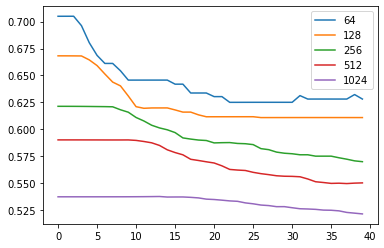

In [544]:
for t in total_loss:
    plt.plot(t)
    
plt.legend([str(b) for b in batch_sizes])

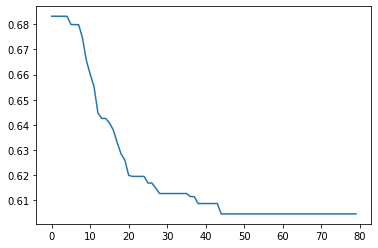

In [512]:
# for t in :
plt.plot(total_loss[0])
    
# plt.legend([str(b) for b in batch_sizes])

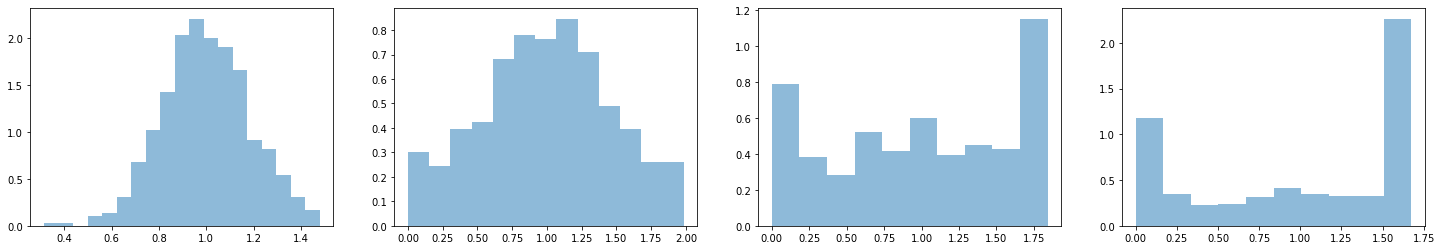

In [519]:
plt.figure(figsize=(25, 4))
for i, t in enumerate(weights):
    plt.subplot(1, len(weights),  i+1)
    plt.hist(weights[t][-1], bins='auto', density=True, alpha=0.5)
    
    # plt.legend([str(batch_sizes[i])])

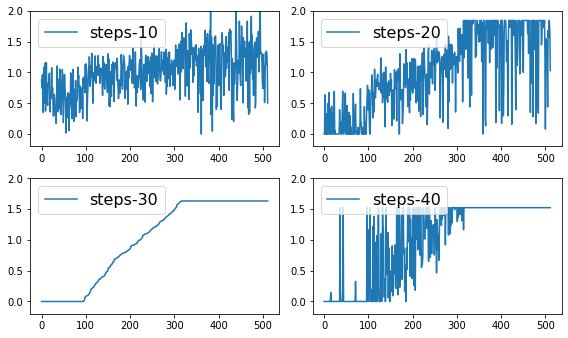

In [548]:
plt.figure(figsize=(8, 4.8))
j = -2
sort_idx = np.argsort(weights[30][j])

for i, t in enumerate([weights[i][j] for i in weights]):
    plt.subplot(2, len(weights)//2,  i+1)
    # plt.hist(t, bins='auto', density=True, alpha=0.5)
    plt.plot(t[sort_idx])
    plt.ylim([-0.2, 2])

    plt.legend(['steps-' + str((i+1) * 10)], fontsize=16, loc='upper left')
plt.tight_layout()

plt.savefig('score_convergence.png')

In [411]:
np.mean([4.605, 4.625, 4.867])

4.699000000000001

(array([ 11.,  23.,  58., 100., 160., 178., 126.,  68.,  38.,   6.]),
 array([0.02689774, 0.21658729, 0.40627682, 0.5959664 , 0.78565592,
        0.97534549, 1.16503501, 1.35472453, 1.54441416, 1.73410368,
        1.9237932 ]),
 <BarContainer object of 10 artists>)

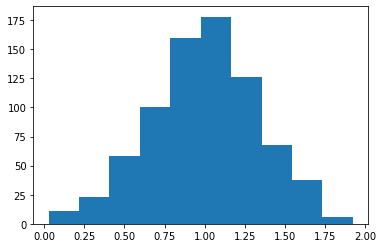

In [343]:
plt.hist(torch.clamp(dloss.w.data.squeeze(), min=0.0, max=2.0, out=None).cpu().numpy())

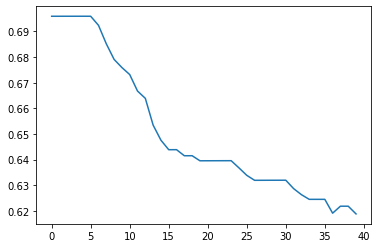

In [269]:
plt.plot(loss)

In [271]:
w = torch.clamp(dloss.w, min=0, max=2, out=None) #dloss.w.data.squeeze().abs()
w /= w.mean()

print(w.squeeze())

tensor([0.1019, 0.0000, 1.6039, 1.6039, 1.6039, 1.6039, 1.6039, 1.6039, 0.0000,
        0.0000, 1.6039, 0.0000, 0.0000, 0.0000, 0.0000, 1.6039, 0.0000, 0.0000,
        1.6039, 1.6039, 0.0000, 0.0000, 1.6039, 1.6039, 1.6039, 1.6039, 1.6039,
        0.0000, 0.0000, 0.0000, 0.0000, 1.6039, 1.6039, 1.6039, 0.0000, 1.6039,
        1.6039, 0.0000, 1.6039, 1.6039, 0.0000, 0.0000, 1.6039, 1.6039, 1.6039,
        1.6039, 1.6039, 1.6039, 1.6039, 0.0000, 1.6039, 0.1770, 1.6039, 1.6039,
        1.6039, 0.0000, 0.0000, 1.6039, 1.6039, 1.6039, 1.6039, 1.6039, 1.3998,
        1.5241, 1.6039, 0.8081, 0.0000, 0.0000, 1.6039, 0.0000, 1.6039, 0.0323,
        0.0000, 1.6039, 1.6039, 0.0000, 0.0000, 1.6039, 1.6039, 1.6039, 0.0000,
        1.6039, 1.6039, 1.6039, 1.6039, 1.6039, 0.0000, 0.0000, 0.5347, 1.6039,
        1.6039, 1.6039, 1.6039, 1.6039, 0.0000, 1.6039], device='cuda:1',
       grad_fn=<SqueezeBackward0>)


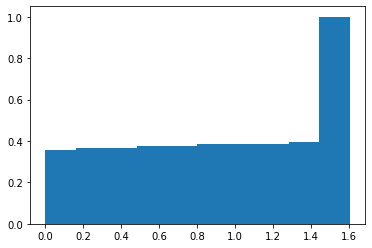

In [272]:
_ = plt.hist(w.squeeze().detach().cpu().numpy(), bins=10, density=True, cumulative=True)
plt.savefig('lamda=0.png')

In [83]:
x1.shape, x2.shape

(torch.Size([96, 192]), torch.Size([384, 192]))

In [ ]:
torch.save({'weights': ws}, 'data/vox2/weight.pth')

### Sample balance

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#### Random

### Sample T-SNE

In [21]:
save_path = 'data/vox1_inst'

optimize_vector = 'embeddings'

if optimize_vector == 'embeddings':
    embeddings = torch.load('{}/embeddings.pth'.format(save_path))['embeddings']
elif optimize_vector == 'logits':
    logits = torch.load('{}/logits.pth'.format(save_path))['logits']
elif optimize_vector == 'grads':
    grads = torch.load('{}/grads.pth'.format(save_path))['grads']

In [31]:
scores =  torch.load('{}/scores.mulscale.v1.lr0.1.steps20.time4.batch1024.x2s.pth'.format(save_path))['scores']

In [34]:
sublabels = np.arange(4)
optimize_vector = 'embeddings'

vectors = []
vectors_lab = []
sub_scores = []
for s in sublabels:
    sidx = labels == s

    if optimize_vector == 'embeddings':
        feats = embeddings[sidx].clone()
    elif optimize_vector == 'logits':
        feats = logits[sidx].clone()
    elif optimize_vector == 'grads':
        feats = grads[sidx].clone()
        
    
    sub_scores.append(scores[sidx]) 
    vectors.append(feats)
    vectors_lab.extend([s]*len(feats))
        
vectors = torch.cat(vectors, dim=0)
vectors_lab = np.array(vectors_lab)
sub_scores = torch.cat(sub_scores, dim=0)

In [64]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns
import matplotlib

In [26]:
all_vectors = PCA(n_components=64).fit_transform(vectors.numpy())
c_embedded  = TSNE(n_components=2, learning_rate='auto', init='pca').fit_transform(all_vectors)

In [35]:
embedds = pd.DataFrame(c_embedded, columns=['x', 'y'])
embedds['label'] = vectors_lab
embedds['scores'] = sub_scores.squeeze().numpy()

# embedds['domain'] = domains

In [43]:
score_sort= np.argsort(sub_scores.squeeze().numpy())

In [53]:
embedds[embedds['scores'] <= sub_scores.squeeze().numpy()[score_sort[100]]]
#.loc(score_sort[:100])

,x,y,label,scores
1,-50.401527,0.317670,0,-0.252600
2,-50.558170,2.778502,0,-0.247394
7,-50.067780,-21.063002,0,-0.056656
19,-46.107578,-13.463084,0,-0.492148
22,-45.730377,-10.348448,0,-0.362844
...,...,...,...,...
1090,-24.232710,55.418484,3,-0.142292
1093,-16.272129,50.055405,3,-0.154061
1107,-8.552108,39.274006,3,-0.051230
1113,-22.492676,54.903275,3,-0.341670


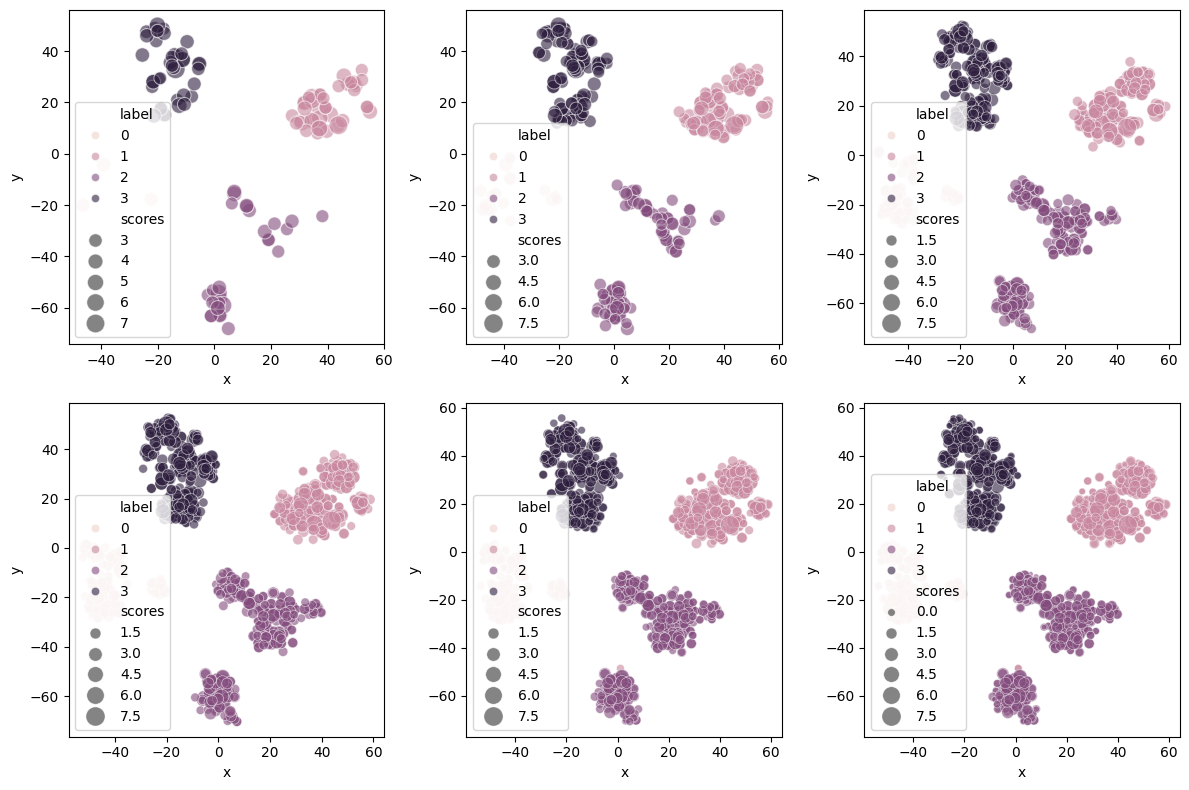

In [70]:
fig = plt.figure(figsize=(12, 8), dpi=100)
# sns.scatterplot(embedds[score_sort[:100]], x='x', y='y', 
#                 hue='label', style='label', 
#                 size='scores', sizes=(50, 500),
#                 alpha=0.6)
ratio = [0.1, 0.25, 0.5, 0.75, 0.9, 1]

for i,r in enumerate(ratio):
    plt.subplot(2, int(np.ceil(len(ratio)/2)), i+1)
    num_samples = int(r*len(embedds))-1
    sns.scatterplot(embedds[embedds['scores'] >= sub_scores[score_sort[-num_samples]]], 
    # sns.scatterplot(embedds[embedds['scores'] <= sub_scores[score_sort[num_samples]]], 
                    x='x', y='y', 
                    size_norm=norm,
                    hue='label', 
                    size='scores', sizes=(10, 200),
                    alpha=0.6)
    plt.tight_layout()

# plt.savefig('imgs/tsne_ecapa.v2_snr05.v1_test.png')

In [65]:
sub_scores = sub_scores.squeeze().numpy()
norm = matplotlib.colors.Normalize(vmin=sub_scores.min(), vmax=sub_scores.max())

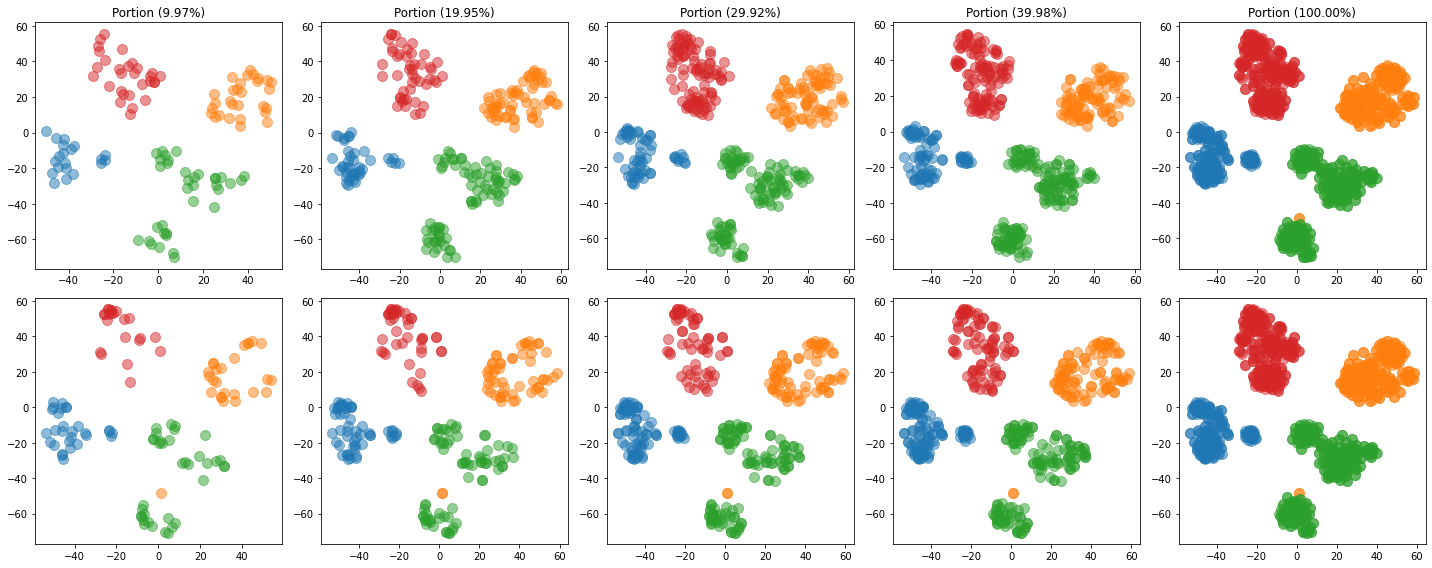

In [75]:
fig = plt.figure(figsize=(20, 8))
 
num_pert = 5
end = num_pert+1

plot_idx = np.arange(4)

labs = vectors_lab
sort_idx = np.argsort(sub_scores)
for i in range(1, num_pert+1):
    
    plt.subplot(2, num_pert, i)
    if i == end-1:
        this_len = len(sort_idx)
    else:
        this_len = int(len(sort_idx)*i/(num_pert*2))
    
    plt.title('Portion ({:.2f}%)'.format(this_len/len(sort_idx)*100))

    part_idx = np.random.choice(np.arange(len(sub_scores)), size=this_len, replace=False)
    s_labs = labs[part_idx]
    
    for idx in plot_idx:
        this_idx = s_labs == idx
        plt.scatter(c_embedded[:, 0][part_idx][this_idx], c_embedded[:, 1][part_idx][this_idx],
                    marker='o', s=100, alpha=0.5)
    
    plt.text('')
    plt.subplot(2,num_pert,i+num_pert)

    part_idx = sort_idx[:this_len]
    s_labs   = labs[part_idx]
    
    for idx in plot_idx:
        
        this_idx = s_labs == idx
        plt.scatter(c_embedded[:, 0][part_idx][this_idx], c_embedded[:, 1][part_idx][this_idx],
                    marker='o', s=100, alpha=0.5)

plt.tight_layout()